#Site-adaptation

El diseño y la puesta en marcha de **soluciones fotovoltaicas eficientes** en un lugar concreto requieren una **caracterización precisa** de la energía solar disponible en la región de interés. Por lo tanto, se necesitan **datos históricos fiables** de la irradiación solar para comprender la variabilidad espacial y temporal a largo plazo del recurso solar. 

**Mediciones satelitales**: alta resolución temporal pero resolución espacial limitada.

**Mediciones in situ**: alta precisión pero con falta de datos.

**Objetivo**: tomar lo mejor de ambas fuentes de datos para obtener una resolución espacio-temporal mejorada, conocida como site-adaptation.




##Datos IDEAM

Datos correspondientes de irradiación solar (W/m^2) a la estación: BOTANA - AUT [52055210]. 

Desde 2006 hasta 2017 con mediciones cada hora. 22% de datos faltantes.

http://dhime.ideam.gov.co/atencionciudadano/

![IDEAM](https://drive.google.com/uc?export=view&id=1xjlD1ZZfuKa5KMiXtFRkBMuR-4f9pwLr)

##Datos NREL

Datos satelitales correspondientes de irradiación solar (global, directa, difusa) (W/m^2), temperatura (°C), velocidad de viento (m/s), y ángulo solar Zenith. Con mediciones desde 1998 hasta 2017 con mediciones cada 30 minutos y resolución espacial de 4 km^2.
https://maps.nrel.gov/nsrdb-viewer

![time_line](https://drive.google.com/uc?export=view&id=1Q0QG-ODIvrf8fBg5gPi84BDW23Vu7lYy)

#Metodología: Site-adpatition

![site_adaptation](https://drive.google.com/uc?export=view&id=1KWzplb4m7ZO2VQEsoVhrUnIaxZSt3812)

#La preparación de los datos representa alrededor del **80% del trabajo**

![pie_chart](https://drive.google.com/uc?export=view&id=18c7n7w7vm1Pvcu-EWAxkh8uwx6WKJ0c_)

https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/?sh=2b27a0ef6f63


#Secciones

[1. Importar librerías](#import_librerias)

[2. Cargar bases de datos](#cargar_imagenes)

[3. Modelos de regresión](#modelos)

[4. Probando mejor modelo en conjunto de prueba](#test)

[5. Guardar mejor modelo](#guardar_modelo)

[6. Pruebas del mejor modelo](#pruebas)

[7. Aplicar el modelo a toda la base de datos satelital](#aplicar_modelo)

[8. Guardar base de datos mejorada](#base_datos_final)

[9. Retos](#retos)

<a name="import_librerias"></a>
#1. Importar librerías

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

<a name="cargar_imagenes"></a>
#2. Cargar bases de datos

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML in PV systems/Site-Adaptation/data_IDEAM_NREL.csv')
data.head(24)

,Fecha,GHI_IDEAM,GHI_NSRDB,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
0,2006-01-01 00:00:00,0,0,0,0,0,7,157
1,2006-01-01 01:00:00,0,0,0,0,0,7,153
2,2006-01-01 02:00:00,0,0,0,0,0,6,142
3,2006-01-01 03:00:00,0,0,0,0,0,6,130
4,2006-01-01 04:00:00,0,0,0,0,0,6,117
5,2006-01-01 05:00:00,0,0,0,0,0,6,103
6,2006-01-01 06:00:00,0,21,11,160,0,6,89
7,2006-01-01 07:00:00,513,219,48,695,1,8,76
8,2006-01-01 08:00:00,1633,480,64,901,1,10,62
9,2006-01-01 09:00:00,1290,368,319,78,1,12,49


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81579 entries, 0 to 81578
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Fecha               81579 non-null  object
 1   GHI_IDEAM           81579 non-null  int64 
 2   GHI_NSRDB           81579 non-null  int64 
 3   DHI                 81579 non-null  int64 
 4   DNI                 81579 non-null  int64 
 5   Wind Speed          81579 non-null  int64 
 6   Temperature         81579 non-null  int64 
 7   Solar Zenith Angle  81579 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 5.0+ MB


###2.1 Comparar IDEAM vs NSRDB

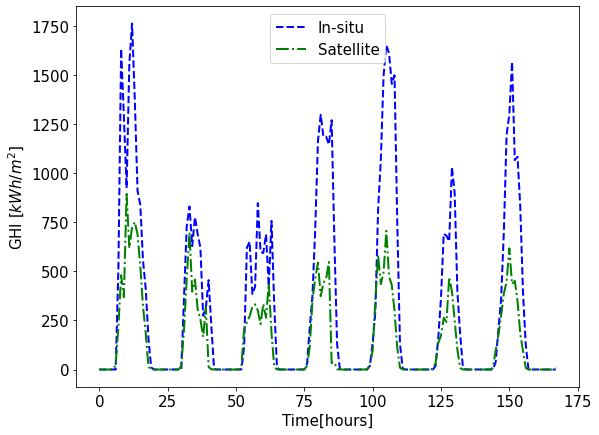

In [ ]:
ghi_ideam = data['GHI_IDEAM'].values
ghi_nsrdb = data['GHI_NSRDB'].values

plt.figure()
plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(ghi_ideam[0:24*7],'--b', label='In-situ', linewidth=2)
plt.plot(ghi_nsrdb[0:24*7],'-.g', label='Satellite', linewidth=2)
plt.legend(loc='best', fontsize=15)
plt.xlabel("Time[hours]", fontsize=15)
plt.xticks(size=15)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=15)
plt.yticks(size=15)
# plt.savefig('/figure.pdf', format='pdf', dpi=300)
plt.show()

In [ ]:
data.corr(method ='pearson')

,GHI_IDEAM,GHI_NSRDB,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
GHI_IDEAM,1.000000,0.808026,0.735807,0.464808,0.260595,0.718470,-0.707808
GHI_NSRDB,0.808026,1.000000,0.832601,0.633091,0.300985,0.741691,-0.737313
DHI,0.735807,0.832601,1.000000,0.168045,0.376760,0.776653,-0.793081
DNI,0.464808,0.633091,0.168045,1.000000,0.052352,0.290528,-0.303762
Wind Speed,0.260595,0.300985,0.376760,0.052352,1.000000,0.421137,-0.526637
Temperature,0.718470,0.741691,0.776653,0.290528,0.421137,1.000000,-0.830112
Solar Zenith Angle,-0.707808,-0.737313,-0.793081,-0.303762,-0.526637,-0.830112,1.000000


###2.2 Agregar la **hora** como variable de entrada

In [ ]:
hora = []
for i in range(len(data['Fecha'])):
    var = data['Fecha'][i][11:13]
    hora.append(var)
data = data.drop(columns='Fecha')
data = pd.DataFrame(np.column_stack((hora,data)))
data = data.rename(columns={0: 'Hora', 1: 'GHI_IDEAM', 2: 'GHI_NSRDB', 3: 'DHI', 4: 'DNI', 
                                                 5: 'Wind Speed', 6: 'Temperature', 7: 'Solar Zenith Angle'})
data.head(24)

,Hora,GHI_IDEAM,GHI_NSRDB,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
0,00,0,0,0,0,0,7,157
1,01,0,0,0,0,0,7,153
2,02,0,0,0,0,0,6,142
3,03,0,0,0,0,0,6,130
4,04,0,0,0,0,0,6,117
5,05,0,0,0,0,0,6,103
6,06,0,21,11,160,0,6,89
7,07,513,219,48,695,1,8,76
8,08,1633,480,64,901,1,10,62
9,09,1290,368,319,78,1,12,49


###2.3 Modelo de Site-adaptation 

![site_adaptation_model](https://drive.google.com/uc?export=view&id=1T2tdbF3isESxpNG67seshObqU9iMP_E4)

<a name="modelos"></a>
#3. Modelos de regresión

###3.1 Mezclar los datos

In [ ]:
from sklearn.utils import shuffle
X_ = data[['Hora','GHI_NSRDB','DHI','DNI','Wind Speed','Temperature','Solar Zenith Angle']]
y_ = data['GHI_IDEAM']
X, y = shuffle(X_, y_, random_state=42)

In [ ]:
X.head(10)

,Hora,GHI_NSRDB,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
8971,03,0,0,0,1,7,129
15889,04,0,0,0,0,5,115
45059,16,177,164,24,3,9,62
65352,16,132,130,6,4,10,63
62415,12,1086,144,963,1,13,12
36552,14,198,186,15,3,10,37
26800,11,291,270,20,2,14,16
24184,10,162,150,12,3,15,26
72488,14,785,225,732,3,13,40
66534,03,0,0,0,0,6,128


###3.2 Normalizar y dividir en: entrenamiento, prueba y validación

In [ ]:
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()

n = len(X)
X_train = X[:round(n*.7)]
X_valid = X[round(n*.7):round(n*.85)]
X_test = X[round(n*.85):]

X_train = X_scaler.fit_transform(X_train)
X_valid = X_scaler.transform(X_valid)
X_test = X_scaler.transform(X_test)

y_scaler = StandardScaler()

y = y.values.reshape(-1, 1)
y_train = y[:round(n*.7)]
y_valid = y[round(n*.7):round(n*.85)]
y_test = y[round(n*.85):]

y_train = y_scaler.fit_transform(y_train).ravel()
y_valid = y_scaler.transform(y_valid).ravel()
y_test = y_scaler.transform(y_test).ravel()

##3.3 Regresión Lineal

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lin_reg = LinearRegression()

lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print('Root mean square error: ', round(rmse,2))
print('Mean absolute error: ', round(mae,2))
print('R-Squared: ', round(r2,2))

Root mean square error:  0.56
Mean absolute error:  0.35
R-Squared:  0.7


##3.4 Random Forest

![random_forest](https://drive.google.com/uc?export=view&id=10UatLP5QQJb35d35hXJF_mAEtwf8VVjM)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100,random_state=42)
forest_reg.fit(X_train,y_train)
y_pred = forest_reg.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print('Root mean square error: ', round(rmse,2))
print('Mean absolute error: ', round(mae,2))
print('R-Squared: ', round(r2,2))

Root mean square error:  0.53
Mean absolute error:  0.27
R-Squared:  0.72


###3.4.1 Feature importance

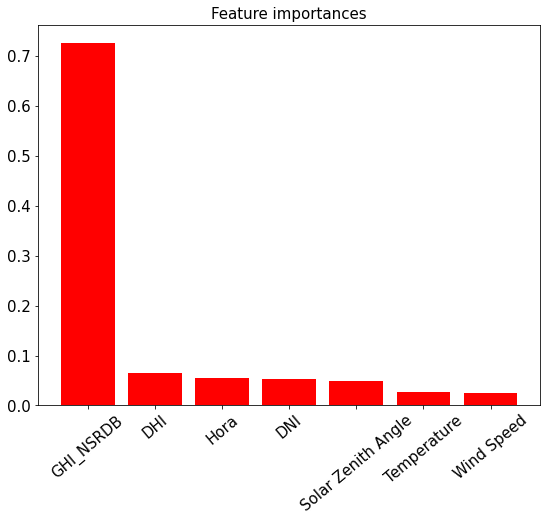

In [ ]:
importances = forest_reg.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_.columns

plt.figure()
plt.title("Feature importances", size=15)
plt.bar(range(X_.shape[1]), importances[indices],
       color="r", align="center")                   
plt.xticks(range(X_.shape[1]), features[indices], rotation=40, size=15)
plt.yticks(size=15)
# plt.savefig('feat_impo.png', format='png', dpi=300)
plt.show()


##3.5 Redes Neuronales

In [ ]:
from sklearn.neural_network import MLPRegressor

rn_reg = MLPRegressor(hidden_layer_sizes=[10], activation='relu', random_state=42, max_iter=500)
rn_reg.fit(X_train, y_train)
y_pred = rn_reg.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print('Root mean square error: ', round(rmse,2))
print('Mean absolute error: ', round(mae,2))
print('R-Squared: ', round(r2,2))

Root mean square error:  0.52
Mean absolute error:  0.27
R-Squared:  0.74


<a name="test"></a>
#4 Probando mejor modelo en conjunto de prueba

In [ ]:
y_pred = rn_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Root mean square error: ', round(rmse,2))
print('Mean absolute error: ', round(mae,2))
print('R-Squared: ', round(r2,2))

Root mean square error:  0.52
Mean absolute error:  0.26
R-Squared:  0.74


<a name="guardar_modelo"></a>
#5 Guardar mejor modelo

In [ ]:
import joblib
joblib.dump(rn_reg, '/content/drive/MyDrive/Colab Notebooks/ML in PV systems/mejor_modelo.pkl')

['/content/drive/MyDrive/Colab Notebooks/ML in PV systems/mejor_modelo.pkl']

<a name="pruebas"></a>
#6 Pruebas del mejor modelo

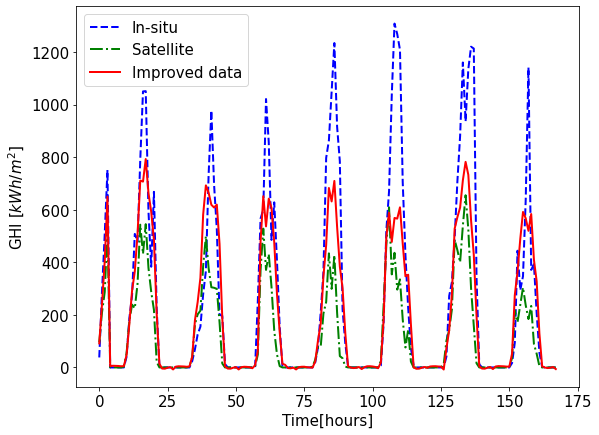

In [ ]:
X_norm = X_scaler.fit_transform(X_)
predictions = rn_reg.predict(X_norm)
y_pred = y_scaler.inverse_transform(predictions)

plt.figure()
plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(ghi_ideam[24*7:24*2*7],'--b', label='In-situ', linewidth=2)
plt.plot(ghi_nsrdb[24*7:24*2*7],'-.g', label='Satellite', linewidth=2)
plt.plot(y_pred[24*7:24*2*7],'r', label='Improved data', linewidth=2)
plt.legend(loc='best', fontsize=15)
plt.xlabel("Time[hours]", fontsize=15)
plt.xticks(size=15)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=15)
plt.yticks(size=15)
# plt.savefig('/figure.pdf', format='pdf', dpi=300)
plt.show()

In [ ]:
data_improved = pd.DataFrame({"GHI_IDEAM": ghi_ideam, "GHI_NSRDB": ghi_nsrdb, "GHI_improved": y_pred})
data_improved.corr(method ='pearson')

,GHI_IDEAM,GHI_NSRDB,GHI_improved
GHI_IDEAM,1.000000,0.808026,0.862362
GHI_NSRDB,0.808026,1.000000,0.934408
GHI_improved,0.862362,0.934408,1.000000


<a name="aplicar_modelo"></a>
#7 Aplicar el modelo a toda la base de datos satelital

In [ ]:
data_NREL = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML in PV systems/Site-Adaptation/data_NREL.csv')
data_NREL.head()

,Date,Year,Month,Day,Hour,Minute,GHI,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
0,1998-01-01 00:00:00,1998,1,1,0,0,0,0,0,0.9,8,157.61
1,1998-01-01 00:30:00,1998,1,1,0,30,0,0,0,0.8,7,157.44
2,1998-01-01 01:00:00,1998,1,1,1,0,0,0,0,0.7,7,155.06
3,1998-01-01 01:30:00,1998,1,1,1,30,0,0,0,0.7,7,150.99
4,1998-01-01 02:00:00,1998,1,1,2,0,0,0,0,0.7,7,145.84


In [ ]:
data_NREL = data_NREL[['Hour','GHI','DHI','DNI','Wind Speed','Temperature','Solar Zenith Angle']]
data_NREL.head()

,Hour,GHI,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
0,0,0,0,0,0.9,8,157.61
1,0,0,0,0,0.8,7,157.44
2,1,0,0,0,0.7,7,155.06
3,1,0,0,0,0.7,7,150.99
4,2,0,0,0,0.7,7,145.84


In [ ]:
var = data_NREL[['GHI','DHI','DNI','Wind Speed','Temperature','Solar Zenith Angle']]
data_NREL_prom = []
for i in range(0,len(data_NREL),2):
    data_NREL_prom.append(np.array((var.iloc[i] + var.iloc[i+1])/2))

hora = []
for i in range(0,len(data_NREL),2):
    hora.append(data_NREL['Hour'][i])

data_NREL_prom = np.column_stack((hora,data_NREL_prom))
data_NREL_prom = pd.DataFrame(data_NREL_prom)
data_NREL_prom = data_NREL_prom.rename(columns={0:'Hour',1:'GHI',2:'DHI',3:'DNI',4:'Wind Speed',5:'Temperature',6:'Solar Zenith Angle'})

In [ ]:
data_NREL_prom.head()

,Hour,GHI,DHI,DNI,Wind Speed,Temperature,Solar Zenith Angle
0,0.0,0.0,0.0,0.0,0.85,7.5,157.525
1,1.0,0.0,0.0,0.0,0.70,7.0,153.025
2,2.0,0.0,0.0,0.0,0.70,6.5,142.935
3,3.0,0.0,0.0,0.0,0.70,6.0,130.575
4,4.0,0.0,0.0,0.0,0.70,6.0,117.310


In [ ]:
scaler = StandardScaler()
data_NREL_norm = X_scaler.fit_transform(data_NREL_prom)

data_impr = forest_reg.predict(data_NREL_norm)
data_impr = y_scaler.inverse_transform(data_impr)

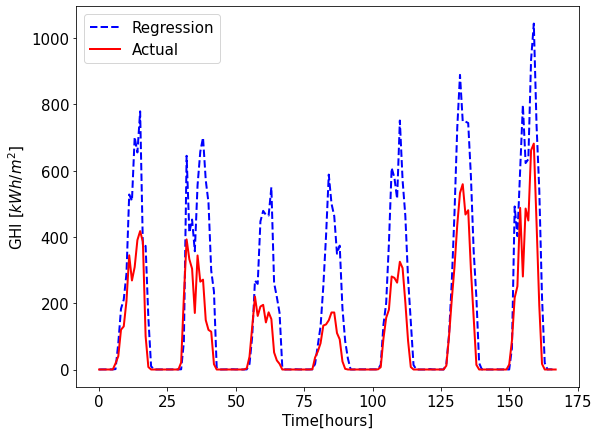

In [ ]:
plt.plot(data_impr[:24*7],'b--', label='Regression', linewidth=2)
plt.plot(data_NREL_prom['GHI'][:24*7],'r', label='Actual', linewidth=2)
plt.legend()
plt.legend(loc='best', fontsize=15)
plt.xlabel("Time[hours]", fontsize=15)
plt.xticks(size=15)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=15)
plt.yticks(size=15)
plt.show()

<a name="base_datos_final"></a>
#8 Guardar base de datos mejorada

In [ ]:
GHI_impr = pd.DataFrame(np.round(data_impr))
GHI_impr.to_csv('/content/drive/MyDrive/Colab Notebooks/ML in PV systems/Site-Adaptation/GHI_impr.csv', index=False)

<a name="retos"></a>
#9. Retos

1. Probar otros métodos de regresión como Support Vector Regression, AdaBoost.
2. Implementar validación cruzada (cross-validation).
3. Probar otras arquitecturas para la red neuronal.

Hint:

from sklearn.svm import SVR

from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score

https://www.sciencedirect.com/science/article/abs/pii/S0960148120318395

